In [1]:
import yfinance
import pandas as pd
import requests
from bs4 import BeautifulSoup

def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df


sectors=fetch_sectors_names()
indusrty=fetch_industry_names()
sectors

,Sector Name,Stocks,Market Cap,Div. Yield,PE Ratio,Profit Margin,1D Change,1Y Change
0,Financials,1385,"9,689.51B",2.41%,14.71,17.75%,0.53%,11.60%
1,Healthcare,1217,"8,168.27B",0.43%,50.93,4.07%,3.29%,7.75%
2,Technology,788,17.72T,0.43%,44.88,13.16%,0.29%,14.87%
3,Industrials,652,"5,478.41B",1.11%,26.71,7.32%,0.55%,17.56%
4,Consumer Discretionary,577,"7,264.64B",0.65%,27.33,5.95%,0.31%,2.23%
5,Real Estate,264,"1,505.41B",4.13%,50.68,8.89%,-0.12%,6.92%
6,Materials,263,"2,069.59B",1.56%,19.61,8.68%,0.47%,2.27%
7,Communication Services,260,"5,361.58B",1.09%,28.01,10.40%,0.29%,2.10%
8,Energy,253,"3,646.11B",2.85%,8.01,12.42%,0.43%,18.22%
9,Consumer Staples,241,"4,035.47B",1.45%,29.74,4.72%,0.44%,12.15%


In [2]:
## Data paths are determined and Symbols are converted to List.

finance_path = '../data/financials/financials.csv'
healthcare_path = '../data/healthcare/healthcare.csv'
technology_path = '../data/technology/technology.csv'
finance = pd.read_csv(finance_path)
finance_list = finance['Symbol'].tolist()
healthcare = pd.read_csv(healthcare_path)
healthcare_list = healthcare['Symbol'].tolist()
technology = pd.read_csv(technology_path)
technology_list = technology['Symbol'].tolist()

### Sector data
Sector data has been tested both monthly and weekly since 2005, 2010 and 2015. However, since most companies today were not in the sector at the mentioned dates, the data of most of the symbols come as NaN. In this case, it was observed that imputation was not a realistic scenario, and the data was collected weekly from 2020 to the present.

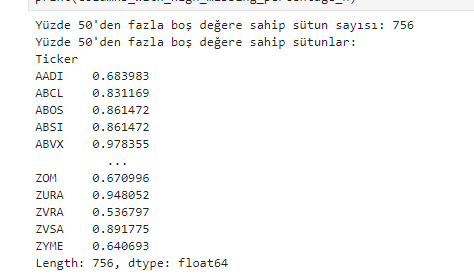
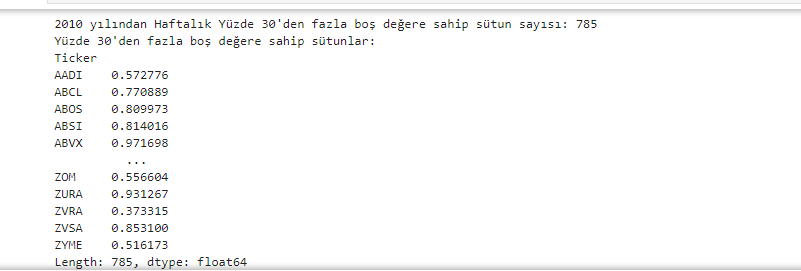
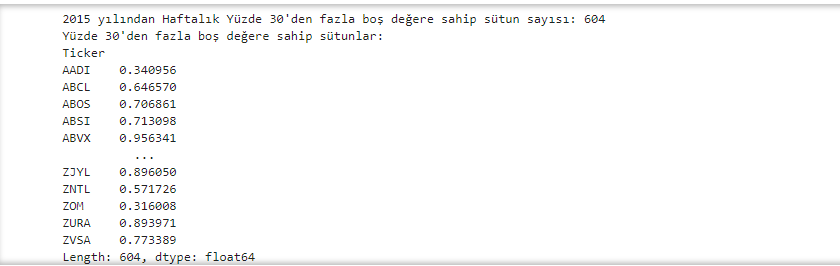

In [3]:
import yfinance as yf

finance_list = finance['Symbol'].tolist()
data_finance = yf.download(finance_list, start='2020-01-01')
data_close_f = data_finance['Adj Close'].resample('W-MON').last().pct_change() + 1

[*********************100%%**********************]  998 of 998 completed

8 Failed downloads:
['BRK.B', 'DISA', 'AGM.A', 'LEGT', 'BNRE.A', 'CRD.B', 'DYCQ', 'CRD.A']: Exception('%ticker%: No timezone found, symbol may be delisted')


### process_data function
First of all, the 4-week momentum return is calculated from the pure data entered into the function. The percentage of missing values ​​in these rolling returns is then calculated.

Columns containing more than 30% missing values ​​are detected and removed from the DataFrame.

Missing values ​​are then predicted using a **KNeighborsRegressor** to fill in the missing values. The predicted data is stored in a variable called m_data_filtered_transformed.

Finally, the data for each stock in the predicted data is considered separately, the date column is added, the stock name column is added, and the results are combined to create a new DataFrame. This DataFrame contains the closing prices of each stock, arranged in chronological order, and each line indicates which company it belongs to.

In [6]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn import set_config
set_config(transform_output="pandas")

def process_data(data, min_missing_percentage=0.30):
    
    def get_rolling_ret(data, n): 
        return data.rolling(n).apply(np.prod)
    
    m_data = get_rolling_ret(data, 4)
    missing_values_percentage = m_data.isna().mean()
    columns_to_drop = missing_values_percentage[missing_values_percentage > min_missing_percentage].index
    m_data_filtered = m_data.drop(columns=columns_to_drop)
    

    imputer_knn = IterativeImputer(estimator=KNeighborsRegressor(), initial_strategy='mean', max_iter=10000, random_state=0)
    m_data_filtered_transformed = imputer_knn.fit_transform(m_data_filtered)
    
    symbols = m_data_filtered_transformed.columns.tolist()
    new_df = pd.DataFrame()

    for ticker in symbols:
        ticker_data = m_data_filtered_transformed[ticker]
        ticker_data = ticker_data.reset_index()
        ticker_data.columns = ['Date', 'Adj Close']
        ticker_data['Company'] = ticker
        new_df = pd.concat([new_df, ticker_data], ignore_index=True)

    new_df = new_df.sort_values(by=['Company', 'Date']).reset_index(drop=True)

    return new_df


finance_data = process_data(data_close_f)
finance_data

,Date,Adj Close,Company
0,2020-01-06,0.979746,AAME
1,2020-01-13,0.979746,AAME
2,2020-01-20,0.979746,AAME
3,2020-01-27,0.979746,AAME
4,2020-02-03,1.037634,AAME
...,...,...,...
152015,2024-02-19,0.948234,ZION
152016,2024-02-26,0.864114,ZION
152017,2024-03-04,1.018331,ZION
152018,2024-03-11,1.019598,ZION


## tsfresh
The tsfresh.extract_features function extracts various features from the given time series dataset using specific columns. These features create a more compact and meaningful dataset that can be used later in machine learning models. In time series analysis, the feature extraction step plays a critical role in enhancing model performance.

In [7]:
import tsfresh
f_features = tsfresh.extract_features(finance_data, column_id='Company', column_sort='Date', 
                                       default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
f_features

Feature Extraction: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


,Adj Close__variance_larger_than_standard_deviation,Adj Close__has_duplicate_max,Adj Close__has_duplicate_min,Adj Close__has_duplicate,Adj Close__sum_values,Adj Close__abs_energy,Adj Close__mean_abs_change,Adj Close__mean_change,Adj Close__mean_second_derivative_central,Adj Close__median,...,Adj Close__fourier_entropy__bins_5,Adj Close__fourier_entropy__bins_10,Adj Close__fourier_entropy__bins_100,Adj Close__permutation_entropy__dimension_3__tau_1,Adj Close__permutation_entropy__dimension_4__tau_1,Adj Close__permutation_entropy__dimension_5__tau_1,Adj Close__permutation_entropy__dimension_6__tau_1,Adj Close__permutation_entropy__dimension_7__tau_1,Adj Close__query_similarity_count__query_None__threshold_0.0,Adj Close__mean_n_absolute_max__number_of_maxima_7
AAME,0.0,0.0,0.0,1.0,225.140007,241.062411,0.096890,0.000640,-0.000037,0.997674,...,0.851215,1.394074,3.036505,1.741259,3.018899,4.207612,4.977275,5.281762,NaN,1.941568
AB,0.0,0.0,0.0,1.0,222.824986,228.004296,0.050663,0.000180,0.000031,1.014213,...,0.285532,0.612434,2.155675,1.672053,2.829157,3.969769,4.724459,5.129465,NaN,1.207870
ABCB,0.0,0.0,0.0,1.0,222.372415,228.197716,0.061811,-0.000122,-0.000022,0.996466,...,0.512769,0.830254,2.346418,1.702299,2.871191,4.031416,4.763641,5.176399,NaN,1.297405
ABL,0.0,0.0,0.0,1.0,221.791151,226.015500,0.029394,-0.000037,0.000183,1.001795,...,0.785156,1.162379,2.318726,1.705220,2.910089,4.086843,4.825281,5.172366,NaN,1.436686
ABTS,0.0,0.0,0.0,1.0,230.923050,277.906072,0.195687,-0.000686,-0.000129,0.975729,...,0.464372,0.759379,2.240670,1.747605,2.976156,4.162101,4.922718,5.262328,NaN,2.436715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WULF,0.0,0.0,0.0,1.0,228.116421,265.425088,0.170925,-0.000659,-0.000114,0.991723,...,0.336840,0.636942,2.196390,1.743247,2.979864,4.145832,4.952253,5.263916,NaN,2.205877
XP,0.0,0.0,0.0,1.0,221.649590,229.963813,0.089759,0.000388,0.000012,0.991636,...,0.562447,0.895520,2.431867,1.737067,2.970047,4.154109,4.896822,5.242037,NaN,1.505906
XYF,0.0,0.0,0.0,1.0,225.897518,249.593769,0.147893,0.000699,-0.000019,0.970588,...,0.496644,0.973263,2.554121,1.736889,2.948272,4.085457,4.856345,5.233113,NaN,1.983801
YRD,0.0,0.0,0.0,1.0,225.263793,245.019600,0.127195,0.000300,-0.000196,0.986939,...,0.561417,0.972078,2.479876,1.754513,2.987077,4.161689,4.936070,5.268806,NaN,1.971663


In [8]:
data_healthcare = yf.download(healthcare_list, start='2020-01-01')
data_close_h = data_healthcare['Adj Close'].resample('W-MON').last().pct_change() + 1
healthcare_data = process_data(data_close_h)
h_features = tsfresh.extract_features(healthcare_data, column_id='Company', column_sort='Date', 
                                       default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
h_features

[*********************100%%**********************]  1217 of 1217 completed

2 Failed downloads:
['CYTK']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
['BIO.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-01 -> 2024-03-18)')
Feature Extraction: 100%|██████████| 20/20 [00:39<00:00,  2.00s/it]


,Adj Close__variance_larger_than_standard_deviation,Adj Close__has_duplicate_max,Adj Close__has_duplicate_min,Adj Close__has_duplicate,Adj Close__sum_values,Adj Close__abs_energy,Adj Close__mean_abs_change,Adj Close__mean_change,Adj Close__mean_second_derivative_central,Adj Close__median,...,Adj Close__fourier_entropy__bins_5,Adj Close__fourier_entropy__bins_10,Adj Close__fourier_entropy__bins_100,Adj Close__permutation_entropy__dimension_3__tau_1,Adj Close__permutation_entropy__dimension_4__tau_1,Adj Close__permutation_entropy__dimension_5__tau_1,Adj Close__permutation_entropy__dimension_6__tau_1,Adj Close__permutation_entropy__dimension_7__tau_1,Adj Close__query_similarity_count__query_None__threshold_0.0,Adj Close__mean_n_absolute_max__number_of_maxima_7
A,0.0,0.0,0.0,1.0,222.827876,227.048113,0.043591,0.000335,-0.000045,1.015457,...,0.609996,0.957560,2.504665,1.723073,2.925518,4.140837,4.843771,5.177256,NaN,1.208896
AADI,0.0,0.0,0.0,1.0,220.539952,232.984246,0.123947,-0.000016,0.000024,0.978237,...,0.644960,1.075063,2.737512,1.727610,2.941155,4.117532,4.830554,5.187767,NaN,1.731955
ABBV,0.0,0.0,0.0,1.0,224.276454,229.777309,0.035452,-0.000102,-0.000082,1.021032,...,0.496644,0.897136,2.251268,1.723920,2.917370,4.068347,4.837263,5.204756,NaN,1.187808
ABCL,0.0,0.0,0.0,1.0,208.488693,203.164407,0.096665,0.000133,-0.000061,0.930434,...,0.441612,0.844742,2.390277,1.689128,2.889911,4.080003,4.813322,5.185322,NaN,1.355974
ABEO,0.0,0.0,0.0,1.0,218.259512,230.332978,0.150847,0.001763,0.000059,0.969416,...,0.626938,0.996894,2.550047,1.717289,2.964803,4.184938,4.933720,5.235559,NaN,1.662590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTEK,0.0,0.0,0.0,1.0,234.346261,269.500963,0.133894,-0.000222,0.000054,1.000000,...,0.543084,0.824266,2.404368,1.739041,2.966390,4.153957,4.905943,5.232790,NaN,2.079784
ZTS,0.0,0.0,0.0,1.0,222.131224,225.508562,0.042254,-0.000578,-0.000039,1.013047,...,0.582424,0.969072,2.694546,1.746584,3.018364,4.222736,4.912796,5.218570,NaN,1.174330
ZVRA,0.0,0.0,0.0,1.0,225.765784,247.295082,0.126174,-0.000284,-0.000295,0.978684,...,0.446050,0.736937,2.180249,1.722474,2.951841,4.074250,4.762331,5.128608,NaN,1.910461
ZYME,0.0,0.0,0.0,1.0,217.876239,222.594474,0.095649,-0.000260,-0.000081,0.966416,...,0.463487,0.697420,2.222884,1.734166,2.937173,4.052100,4.833715,5.184592,NaN,1.432396


In [9]:
technology_list = technology['Symbol'].dropna()
technology_list_dropna = technology_list.tolist()
data_technology = yf.download(technology_list_dropna, start='2020-01-01')
data_close_t = data_technology['Adj Close'].resample('W-MON').last().pct_change() + 1
technology_data = process_data(data_close_t)
t_features = tsfresh.extract_features(technology_data, column_id='Company', column_sort='Date', 
                                       default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
t_features

[*********************100%%**********************]  785 of 785 completed
Feature Extraction: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


,Adj Close__variance_larger_than_standard_deviation,Adj Close__has_duplicate_max,Adj Close__has_duplicate_min,Adj Close__has_duplicate,Adj Close__sum_values,Adj Close__abs_energy,Adj Close__mean_abs_change,Adj Close__mean_change,Adj Close__mean_second_derivative_central,Adj Close__median,...,Adj Close__fourier_entropy__bins_5,Adj Close__fourier_entropy__bins_10,Adj Close__fourier_entropy__bins_100,Adj Close__permutation_entropy__dimension_3__tau_1,Adj Close__permutation_entropy__dimension_4__tau_1,Adj Close__permutation_entropy__dimension_5__tau_1,Adj Close__permutation_entropy__dimension_6__tau_1,Adj Close__permutation_entropy__dimension_7__tau_1,Adj Close__query_similarity_count__query_None__threshold_0.0,Adj Close__mean_n_absolute_max__number_of_maxima_7
AAOI,0.0,0.0,0.0,1.0,229.916561,266.456873,0.131559,-0.001962,-0.000197,0.957122,...,0.299495,0.590325,1.876660,1.659043,2.821620,3.923334,4.674629,5.079229,NaN,2.342841
AAPL,0.0,0.0,0.0,1.0,224.139807,229.911801,0.045483,-0.000289,0.000055,1.021333,...,0.387471,0.665225,2.185464,1.744128,2.970361,4.153130,4.901877,5.223460,NaN,1.207158
ACIW,0.0,0.0,0.0,1.0,220.591880,223.552609,0.053957,0.000051,-0.000003,0.994735,...,0.479391,0.896783,2.590667,1.728037,2.973870,4.191194,4.935217,5.246927,NaN,1.288287
ACLS,0.0,0.0,0.0,1.0,229.272517,244.521838,0.093343,-0.000855,0.000004,1.029060,...,0.734938,1.221823,2.885839,1.749383,2.982159,4.185198,4.905943,5.272839,NaN,1.439262
ACMR,0.0,0.0,0.0,1.0,230.832570,255.249471,0.147426,0.000989,-0.000205,1.030522,...,0.619647,1.031768,2.564975,1.745131,2.950719,4.100390,4.832260,5.190212,NaN,1.720330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFOX,0.0,0.0,0.0,1.0,214.625917,215.965874,0.076154,0.000033,0.000020,1.001001,...,0.629572,1.064159,2.651858,1.722905,2.960498,4.173709,4.956350,5.279317,NaN,1.483186
ZI,0.0,0.0,0.0,1.0,218.723330,222.428179,0.093012,-0.000637,-0.000294,1.000329,...,0.587164,0.938166,2.523708,1.695931,2.897200,4.093319,4.791866,5.192658,NaN,1.352286
ZM,0.0,0.0,0.0,1.0,221.865472,229.898890,0.079724,0.001003,-0.000043,0.987131,...,0.357366,0.661920,2.078064,1.708430,2.871435,4.018403,4.763724,5.121807,NaN,1.519204
ZS,0.0,0.0,0.0,1.0,228.556003,243.210205,0.089792,-0.001454,-0.000053,1.045690,...,0.624452,0.971702,2.649929,1.694364,2.883305,4.056188,4.804762,5.167476,NaN,1.461209


Labels are assigned to 3 major Sectors and necessary Dataframe operations are carried out.

**Finance = 'F'**

**Healthcare = 'H'**

**Technology = 'T'**


In [124]:
f_features['Sector'] = 'F'
h_features['Sector'] = 'H'
t_features['Sector'] = 'T'
merged_df = pd.concat([f_features, h_features, t_features])
df_reset = merged_df.reset_index()
df_without_index = df_reset.drop(columns=['index'])
df_without_index

,Adj Close__variance_larger_than_standard_deviation,Adj Close__has_duplicate_max,Adj Close__has_duplicate_min,Adj Close__has_duplicate,Adj Close__sum_values,Adj Close__abs_energy,Adj Close__mean_abs_change,Adj Close__mean_change,Adj Close__mean_second_derivative_central,Adj Close__median,...,Adj Close__fourier_entropy__bins_10,Adj Close__fourier_entropy__bins_100,Adj Close__permutation_entropy__dimension_3__tau_1,Adj Close__permutation_entropy__dimension_4__tau_1,Adj Close__permutation_entropy__dimension_5__tau_1,Adj Close__permutation_entropy__dimension_6__tau_1,Adj Close__permutation_entropy__dimension_7__tau_1,Adj Close__query_similarity_count__query_None__threshold_0.0,Adj Close__mean_n_absolute_max__number_of_maxima_7,Sector
0,0.0,0.0,0.0,1.0,225.140007,241.062411,0.096890,0.000640,-0.000037,0.997674,...,1.394074,3.036505,1.741259,3.018899,4.207612,4.977275,5.281762,NaN,1.941568,F
1,0.0,0.0,0.0,1.0,222.824986,228.004296,0.050663,0.000180,0.000031,1.014213,...,0.612434,2.155675,1.672053,2.829157,3.969769,4.724459,5.129465,NaN,1.207870,F
2,0.0,0.0,0.0,1.0,222.372415,228.197716,0.061811,-0.000122,-0.000022,0.996466,...,0.830254,2.346418,1.702299,2.871191,4.031416,4.763641,5.176399,NaN,1.297405,F
3,0.0,0.0,0.0,1.0,221.791151,226.015500,0.029394,-0.000037,0.000183,1.001795,...,1.162379,2.318726,1.705220,2.910089,4.086843,4.825281,5.172366,NaN,1.436686,F
4,0.0,0.0,0.0,1.0,230.923050,277.906072,0.195687,-0.000686,-0.000129,0.975729,...,0.759379,2.240670,1.747605,2.976156,4.162101,4.922718,5.262328,NaN,2.436715,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,0.0,0.0,0.0,1.0,214.625917,215.965874,0.076154,0.000033,0.000020,1.001001,...,1.064159,2.651858,1.722905,2.960498,4.173709,4.956350,5.279317,NaN,1.483186,T
2246,0.0,0.0,0.0,1.0,218.723330,222.428179,0.093012,-0.000637,-0.000294,1.000329,...,0.938166,2.523708,1.695931,2.897200,4.093319,4.791866,5.192658,NaN,1.352286,T
2247,0.0,0.0,0.0,1.0,221.865472,229.898890,0.079724,0.001003,-0.000043,0.987131,...,0.661920,2.078064,1.708430,2.871435,4.018403,4.763724,5.121807,NaN,1.519204,T
2248,0.0,0.0,0.0,1.0,228.556003,243.210205,0.089792,-0.001454,-0.000053,1.045690,...,0.971702,2.649929,1.694364,2.883305,4.056188,4.804762,5.167476,NaN,1.461209,T


Again, we determine the columns containing more than 30% NaN values ​​as the threshold value and remove them from our data.

In [125]:
# Let's print columns containing more than 30% NaN values

nan_ratios = df_without_index.isna().mean()
nan_columns = nan_ratios[nan_ratios > 0.3].index
print("NaN değer oranı %30'dan fazla olan sütunlar:")
print(nan_columns)

NaN değer oranı %30'dan fazla olan sütunlar:
Index(['Adj Close__query_similarity_count__query_None__threshold_0.0'], dtype='object')


In [126]:
df_without_index.drop('Adj Close__query_similarity_count__query_None__threshold_0.0', axis=1, inplace=True)
df_without_index

,Adj Close__variance_larger_than_standard_deviation,Adj Close__has_duplicate_max,Adj Close__has_duplicate_min,Adj Close__has_duplicate,Adj Close__sum_values,Adj Close__abs_energy,Adj Close__mean_abs_change,Adj Close__mean_change,Adj Close__mean_second_derivative_central,Adj Close__median,...,Adj Close__fourier_entropy__bins_5,Adj Close__fourier_entropy__bins_10,Adj Close__fourier_entropy__bins_100,Adj Close__permutation_entropy__dimension_3__tau_1,Adj Close__permutation_entropy__dimension_4__tau_1,Adj Close__permutation_entropy__dimension_5__tau_1,Adj Close__permutation_entropy__dimension_6__tau_1,Adj Close__permutation_entropy__dimension_7__tau_1,Adj Close__mean_n_absolute_max__number_of_maxima_7,Sector
0,0.0,0.0,0.0,1.0,225.140007,241.062411,0.096890,0.000640,-0.000037,0.997674,...,0.851215,1.394074,3.036505,1.741259,3.018899,4.207612,4.977275,5.281762,1.941568,F
1,0.0,0.0,0.0,1.0,222.824986,228.004296,0.050663,0.000180,0.000031,1.014213,...,0.285532,0.612434,2.155675,1.672053,2.829157,3.969769,4.724459,5.129465,1.207870,F
2,0.0,0.0,0.0,1.0,222.372415,228.197716,0.061811,-0.000122,-0.000022,0.996466,...,0.512769,0.830254,2.346418,1.702299,2.871191,4.031416,4.763641,5.176399,1.297405,F
3,0.0,0.0,0.0,1.0,221.791151,226.015500,0.029394,-0.000037,0.000183,1.001795,...,0.785156,1.162379,2.318726,1.705220,2.910089,4.086843,4.825281,5.172366,1.436686,F
4,0.0,0.0,0.0,1.0,230.923050,277.906072,0.195687,-0.000686,-0.000129,0.975729,...,0.464372,0.759379,2.240670,1.747605,2.976156,4.162101,4.922718,5.262328,2.436715,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,0.0,0.0,0.0,1.0,214.625917,215.965874,0.076154,0.000033,0.000020,1.001001,...,0.629572,1.064159,2.651858,1.722905,2.960498,4.173709,4.956350,5.279317,1.483186,T
2246,0.0,0.0,0.0,1.0,218.723330,222.428179,0.093012,-0.000637,-0.000294,1.000329,...,0.587164,0.938166,2.523708,1.695931,2.897200,4.093319,4.791866,5.192658,1.352286,T
2247,0.0,0.0,0.0,1.0,221.865472,229.898890,0.079724,0.001003,-0.000043,0.987131,...,0.357366,0.661920,2.078064,1.708430,2.871435,4.018403,4.763724,5.121807,1.519204,T
2248,0.0,0.0,0.0,1.0,228.556003,243.210205,0.089792,-0.001454,-0.000053,1.045690,...,0.624452,0.971702,2.649929,1.694364,2.883305,4.056188,4.804762,5.167476,1.461209,T


In [127]:
X = df_without_index.drop(columns=['Sector'])
y = df_without_index['Sector']

### Impute and Drop

**IterativeImputer**: Fills in missing values ​​using the KNeighborsRegressor estimator.

**DropConstantFeatures**: This step drops features (constant features) that have the same value across all instances.

**DropDuplicateFeatures**: This step removes features that are duplicated after other steps. If there are two or more properties with the same data, it keeps only one. It can help reduce unnecessary information in the data set.

In [128]:
from sklearn import set_config
from sklearn.feature_selection import VarianceThreshold
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline

set_config(transform_output="pandas")

selector_drop = Pipeline(steps=[
    ('mice', IterativeImputer(estimator=KNeighborsRegressor(), initial_strategy='mean', max_iter=1000, random_state=0)),
    ('constant_var', DropConstantFeatures(tol=0.8)),
    ('duplicated_var', DropDuplicateFeatures())
])

selector_drop.fit(X)
X = selector_drop.transform(X)

In [129]:
X

,Adj Close__sum_values,Adj Close__abs_energy,Adj Close__mean_abs_change,Adj Close__mean_change,Adj Close__mean_second_derivative_central,Adj Close__median,Adj Close__mean,Adj Close__standard_deviation,Adj Close__variation_coefficient,Adj Close__variance,...,Adj Close__fourier_entropy__bins_3,Adj Close__fourier_entropy__bins_5,Adj Close__fourier_entropy__bins_10,Adj Close__fourier_entropy__bins_100,Adj Close__permutation_entropy__dimension_3__tau_1,Adj Close__permutation_entropy__dimension_4__tau_1,Adj Close__permutation_entropy__dimension_5__tau_1,Adj Close__permutation_entropy__dimension_6__tau_1,Adj Close__permutation_entropy__dimension_7__tau_1,Adj Close__mean_n_absolute_max__number_of_maxima_7
0,225.140007,241.062411,0.096890,0.000640,-0.000037,0.997674,1.023364,0.220148,0.215122,0.048465,...,0.511200,0.851215,1.394074,3.036505,1.741259,3.018899,4.207612,4.977275,5.281762,1.941568
1,222.824986,228.004296,0.050663,0.000180,0.000031,1.014213,1.012841,0.102648,0.101346,0.010537,...,0.213975,0.285532,0.612434,2.155675,1.672053,2.829157,3.969769,4.724459,5.129465,1.207870
2,222.372415,228.197716,0.061811,-0.000122,-0.000022,0.996466,1.010784,0.124814,0.123483,0.015579,...,0.306646,0.512769,0.830254,2.346418,1.702299,2.871191,4.031416,4.763641,5.176399,1.297405
3,221.791151,226.015500,0.029394,-0.000037,0.000183,1.001795,1.008142,0.104851,0.104004,0.010994,...,0.534032,0.785156,1.162379,2.318726,1.705220,2.910089,4.086843,4.825281,5.172366,1.436686
4,230.923050,277.906072,0.195687,-0.000686,-0.000129,0.975729,1.049650,0.401801,0.382795,0.161444,...,0.273042,0.464372,0.759379,2.240670,1.747605,2.976156,4.162101,4.922718,5.262328,2.436715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,214.625917,215.965874,0.076154,0.000033,0.000020,1.001001,0.975572,0.172979,0.177310,0.029922,...,0.363378,0.629572,1.064159,2.651858,1.722905,2.960498,4.173709,4.956350,5.279317,1.483186
2246,218.723330,222.428179,0.093012,-0.000637,-0.000294,1.000329,0.994197,0.150365,0.151243,0.022610,...,0.347828,0.587164,0.938166,2.523708,1.695931,2.897200,4.093319,4.791866,5.192658,1.352286
2247,221.865472,229.898890,0.079724,0.001003,-0.000043,0.987131,1.008479,0.167225,0.165819,0.027964,...,0.206199,0.357366,0.661920,2.078064,1.708430,2.871435,4.018403,4.763724,5.121807,1.519204
2248,228.556003,243.210205,0.089792,-0.001454,-0.000053,1.045690,1.038891,0.161884,0.155824,0.026207,...,0.411422,0.624452,0.971702,2.649929,1.694364,2.883305,4.056188,4.804762,5.167476,1.461209


A selection process is performed to select features that are associated with a specific target variable (Sectors). It aims to select the most important or meaningful features among the features in the data set. The selection process is done by evaluating the relationship of the features with the target variable.

In [32]:
from tsfresh import select_features

X = select_features(X, y)
X

,"Adj Close__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2",Adj Close__quantile__q_0.1,"Adj Close__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","Adj Close__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","Adj Close__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.2","Adj Close__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2",Adj Close__quantile__q_0.2,"Adj Close__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.0","Adj Close__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","Adj Close__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2",...,"Adj Close__fft_coefficient__attr_""real""__coeff_24","Adj Close__fft_coefficient__attr_""imag""__coeff_48","Adj Close__fft_coefficient__attr_""angle""__coeff_99","Adj Close__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)","Adj Close__fft_coefficient__attr_""imag""__coeff_51",Adj Close__ratio_beyond_r_sigma__r_1.5,Adj Close__autocorrelation__lag_6,"Adj Close__fft_coefficient__attr_""real""__coeff_16",Adj Close__sample_entropy,"Adj Close__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)"
0,0.001415,0.855342,0.000528,0.029796,0.028210,0.001126,0.907601,0.050450,0.001211,0.002940,...,-0.554172,0.431136,38.975976,-0.278220,-0.120215,0.036364,-0.058463,-0.474118,1.053107,0.482772
1,0.000919,0.906891,0.000364,0.025337,0.017466,0.000537,0.944504,0.043663,0.000621,0.001612,...,-1.935228,-0.114838,103.118787,-0.799677,-0.155067,0.090909,-0.216017,1.874484,1.504813,0.491721
2,0.001241,0.883620,0.000442,0.028307,0.015227,0.000310,0.928537,0.050284,0.000971,0.002603,...,-3.999687,0.604338,-27.366728,-0.589099,-0.440421,0.113636,-0.015687,0.767633,1.445370,0.570208
3,0.000005,0.964304,0.000002,0.001502,0.000894,0.000002,0.996547,0.019680,0.000004,0.000008,...,0.671940,0.229423,22.597482,0.013383,-0.043862,0.081818,-0.171742,2.155532,0.152088,0.556019
4,0.004611,0.682274,0.001533,0.055555,0.051217,0.003348,0.805707,0.100715,0.004511,0.010097,...,-8.750471,0.098121,-149.828600,-0.400820,-0.815338,0.113636,0.180514,-9.532325,1.055032,0.533107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,0.000296,0.763724,0.000233,0.008079,0.008876,0.000154,0.903833,0.055197,0.000278,0.000355,...,-3.840271,-1.477019,124.080519,-0.051774,0.297570,0.122727,0.228250,0.017142,0.255125,0.621290
2246,0.003396,0.811431,0.001070,0.048712,0.027540,0.000896,0.865362,0.074308,0.002496,0.006485,...,-2.811136,-0.006598,-121.371237,-0.266706,-0.992269,0.136364,-0.022208,2.077887,1.937080,0.632081
2247,0.002259,0.830901,0.000774,0.038635,0.023372,0.000739,0.872165,0.053532,0.001573,0.004107,...,0.465861,0.687774,92.505062,0.220142,0.198664,0.109091,0.085333,-1.282441,1.442158,0.229134
2248,0.003181,0.825995,0.001680,0.044078,0.028238,0.001352,0.900350,0.076753,0.002108,0.004667,...,-4.913047,0.475388,69.114989,0.034630,-0.297991,0.140909,0.035431,1.138582,1.572545,0.606334


### Feature Selection
SmartCorrelatedSelection class in the Feature Engine library was used for feature selection.
It is to select highly correlated features over a certain threshold value and optimize a certain model performance during this selection process. In this way, the model is aimed to work better with less correlated features.
Since it is a multi-class classification problem, multi-class classification is configured using **OneVsRestClassifier**.

In [130]:
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

estimator = RandomForestClassifier(random_state=0)
estimator_ovr = OneVsRestClassifier(estimator)

selector_corr = SmartCorrelatedSelection(
    method='pearson',
    threshold=0.90,
    selection_method='model_performance',
    estimator=estimator_ovr,
    scoring='roc_auc_ovr',
    cv=5
)

selector_corr.fit(X, y.to_numpy().ravel())
X = selector_corr.transform(X)
X

,Adj Close__mean_change,Adj Close__mean_second_derivative_central,Adj Close__variation_coefficient,Adj Close__skewness,Adj Close__kurtosis,Adj Close__longest_strike_below_mean,Adj Close__longest_strike_above_mean,Adj Close__count_above_mean,Adj Close__last_location_of_maximum,Adj Close__first_location_of_minimum,...,Adj Close__ratio_beyond_r_sigma__r_3,Adj Close__ratio_beyond_r_sigma__r_5,Adj Close__lempel_ziv_complexity__bins_2,Adj Close__lempel_ziv_complexity__bins_3,Adj Close__lempel_ziv_complexity__bins_5,Adj Close__fourier_entropy__bins_2,Adj Close__fourier_entropy__bins_5,Adj Close__fourier_entropy__bins_100,Adj Close__permutation_entropy__dimension_5__tau_1,Adj Close__permutation_entropy__dimension_7__tau_1
0,0.000640,-0.000037,0.215122,4.321094,27.667646,27.0,11.0,87.0,0.263636,0.277273,...,0.018182,0.009091,0.104545,0.118182,0.236364,0.302746,0.851215,3.036505,4.207612,5.281762
1,0.000180,0.000031,0.101346,-1.392689,5.625225,11.0,12.0,113.0,0.072727,0.050000,...,0.018182,0.004545,0.140909,0.227273,0.240909,0.090222,0.285532,2.155675,3.969769,5.129465
2,-0.000122,-0.000022,0.123483,-0.369973,2.218550,14.0,26.0,100.0,0.209091,0.050000,...,0.009091,0.000000,0.177273,0.213636,0.259091,0.183659,0.512769,2.346418,4.031416,5.176399
3,-0.000037,0.000183,0.104004,1.687924,13.464042,75.0,15.0,48.0,0.954545,0.845455,...,0.040909,0.004545,0.118182,0.145455,0.218182,0.342542,0.785156,2.318726,4.086843,5.172366
4,-0.000686,-0.000129,0.382795,1.610576,3.855334,28.0,11.0,77.0,0.731818,0.377273,...,0.027273,0.000000,0.150000,0.204545,0.259091,0.124251,0.464372,2.240670,4.162101,5.262328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,0.000033,0.000020,0.177310,-0.097530,3.675162,13.0,72.0,158.0,0.981818,0.759091,...,0.018182,0.000000,0.154545,0.177273,0.227273,0.210283,0.629572,2.651858,4.173709,5.279317
2246,-0.000637,-0.000294,0.151243,0.134801,0.138094,12.0,10.0,111.0,0.622727,0.686364,...,0.000000,0.000000,0.218182,0.240909,0.313636,0.258966,0.587164,2.523708,4.093319,5.192658
2247,0.001003,-0.000043,0.165819,0.946269,1.563877,20.0,15.0,98.0,0.172727,0.518182,...,0.013636,0.000000,0.159091,0.231818,0.281818,0.051397,0.357366,2.078064,4.018403,5.121807
2248,-0.001454,-0.000053,0.155824,0.227915,0.682332,15.0,14.0,118.0,0.100000,0.559091,...,0.004545,0.000000,0.200000,0.218182,0.295455,0.210283,0.624452,2.649929,4.056188,5.167476


### Unbalanced Class Distribution
It uses the **SMOTE (Synthetic Reduction Technique)** method to address class imbalance in a dataset with unbalanced class distribution. SMOTE aims to reduce class imbalance by synthetically creating instances of underrepresented classes.

In [131]:
classes, counts = np.unique(y, return_counts=True)

# Her sınıfın örnek sayısını yazdır
for c, count in zip(classes, counts):
    print(f"Sınıf {c}: {count} örnek")

from imblearn.over_sampling import SMOTE

print(X.shape)
# SMOTE uygulama
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# SMOTE uygulandıktan sonra eğitim setinin boyutunu kontrol etme
print("Eğitim seti boyutu (SMOTE sonrası):", X_resampled.shape)

Sınıf F: 691 örnek
Sınıf H: 957 örnek
Sınıf T: 602 örnek
(2250, 290)
Eğitim seti boyutu (SMOTE sonrası): (2871, 290)


Randomized Search Cross Validation method was used to quickly search different classification models (LogisticRegression, RandomForestClassifier, SVC, GradientBoostingClassifier, KNeighborsClassifier) ​​and the hyperparameters of these models.

The Pipeline object combines the data preprocessing steps and the classification model. These steps include data preprocessing (Winsorizer and StandardScaler), dimensionality reduction (PCA), and feature selection (RFE).

The distribution of hyperparameters is determined for each classification model. The RandomizedSearchCV function tries to find the best model by selecting random parameter combinations from these distributions.

In [132]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from feature_engine.outliers import Winsorizer
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint
from scipy.stats import randint, uniform



pipeline = Pipeline([
    ('winsorizer', Winsorizer(capping_method='gaussian', tail='both')),
    ('scaler', StandardScaler()),  # Scaling data
    ('pca', PCA()),  # PCA
    ('feature_selection', RFE(estimator=RandomForestClassifier())),  # Feature Selection
    ('classifier', LogisticRegression())  # Classification model
])

params_LR = {}
params_LR['pca__n_components'] = randint(20, 50)
params_LR['feature_selection__n_features_to_select'] = randint(10, 20)
params_LR['classifier__C'] = uniform(0.1, 10)
params_LR['classifier__solver'] = ['liblinear', 'saga']
params_LR['classifier'] = [LogisticRegression()]

params_RFC = {}
params_RFC['pca__n_components'] = randint(20, 50)
params_RFC['feature_selection__n_features_to_select'] = randint(10, 20)
params_RFC['classifier__n_estimators'] = randint(100, 1000)
params_RFC['classifier__max_depth'] = [20, 30, 40]
params_RFC['classifier'] = [RandomForestClassifier()]

params_SVM = {}
params_SVM['pca__n_components'] = randint(20, 50)
params_SVM['feature_selection__n_features_to_select'] = randint(10, 20)
params_SVM['classifier__C'] = uniform(0.1, 10)
params_SVM['classifier__kernel'] = ['linear', 'rbf', 'poly']
params_SVM['classifier'] = [SVC()]

params_GB = {}
params_GB['pca__n_components'] = randint(20, 50)
params_GB['feature_selection__n_features_to_select'] = randint(10, 20)
params_GB['classifier__n_estimators'] = randint(100, 1000)
params_GB['classifier__learning_rate'] = uniform(0.01, 0.5)
params_GB['classifier__max_depth'] = [3, 5, 7]
params_GB['classifier'] = [GradientBoostingClassifier()]

params_KNN = {}
params_KNN['pca__n_components'] = randint(20, 50)
params_KNN['feature_selection__n_features_to_select'] = randint(10, 20)
params_KNN['classifier__n_neighbors'] = randint(3, 15)
params_KNN['classifier__weights'] = ['uniform', 'distance']
params_KNN['classifier'] = [KNeighborsClassifier()]


params = [params_LR, params_RFC, params_SVM, params_GB, params_KNN]

encoder = LabelEncoder()
y_deneme = encoder.fit_transform(y_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)

random_search = RandomizedSearchCV(pipeline, params, n_iter=5, cv=10, scoring='accuracy', random_state=0)

random_search.fit(X_train, y_train)

# Printing best parameters and best score
print("En iyi parametreler:", random_search.best_params_)
print("En iyi skor:", random_search.best_score_)

# Selecting best model
best_model = random_search.best_estimator_
print("En iyi model:", type(best_model.named_steps['classifier']).__name__)

# Testing on the test set with the best model
accuracy = best_model.score(X_test, y_test)
print("Test seti doğruluğu:", accuracy)

y_pred = best_model.predict(X_test)

En iyi parametreler: {'classifier': GradientBoostingClassifier(), 'classifier__learning_rate': 0.4336258693920627, 'classifier__max_depth': 5, 'classifier__n_estimators': 854, 'feature_selection__n_features_to_select': 14, 'pca__n_components': 43}
En iyi skor: 0.758092039800995
En iyi model: GradientBoostingClassifier
Test seti doğruluğu: 0.771461716937355


In [133]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='macro')
print("\nF1 Score:", f1)

Confusion Matrix:
[[236  25  26]
 [ 13 212  70]
 [ 12  51 217]]

Classification Report:
              precision    recall  f1-score   support

           F       0.90      0.82      0.86       287
           H       0.74      0.72      0.73       295
           T       0.69      0.78      0.73       280

    accuracy                           0.77       862
   macro avg       0.78      0.77      0.77       862
weighted avg       0.78      0.77      0.77       862


F1 Score: 0.7734861446657214


In [134]:
import joblib
joblib.dump(best_model, '../best_model.pkl')

['../OsmanSefaYüksel - TUBİTAK Proje/best_model.pkl']

In [136]:
energy_path = '../data/energy/energy.csv'
energy = pd.read_csv(energy_path)
energy_list = energy['Symbol'].tolist()
data_energy = yf.download(energy_list, start='2020-01-01')
data_close_e = data_energy['Adj Close'].resample('W-MON').last().pct_change() + 1
energy_data = process_data(data_close_e)
e_features = tsfresh.extract_features(energy_data, column_id='Company', column_sort='Date', 
                                       default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
e_features['Sector'] = 'E'
df_reset_e = e_features.reset_index()
df_without_index_e = df_reset_e.drop(columns=['index'])


[*********************100%%**********************]  252 of 252 completed

1 Failed download:
['PBR.A']: Exception('%ticker%: No timezone found, symbol may be delisted')
Feature Extraction: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


In [140]:
nan_ratios = df_without_index_e.isna().mean()
nan_columns = nan_ratios[nan_ratios > 0.3].index
print("NaN değer oranı %30'dan fazla olan sütunlar:")
print(nan_columns)

NaN değer oranı %30'dan fazla olan sütunlar:
Index([], dtype='object')


In [191]:
X_e = df_without_index_e.drop(columns=['Sector'])

In [193]:
selector_drop.fit(X_e)
X_e = selector_drop.transform(X_e)


In [195]:
X_e = X_e[X_test.columns]
X_e

,Adj Close__mean_change,Adj Close__mean_second_derivative_central,Adj Close__variation_coefficient,Adj Close__skewness,Adj Close__kurtosis,Adj Close__longest_strike_below_mean,Adj Close__longest_strike_above_mean,Adj Close__count_above_mean,Adj Close__last_location_of_maximum,Adj Close__first_location_of_minimum,...,Adj Close__ratio_beyond_r_sigma__r_3,Adj Close__ratio_beyond_r_sigma__r_5,Adj Close__lempel_ziv_complexity__bins_2,Adj Close__lempel_ziv_complexity__bins_3,Adj Close__lempel_ziv_complexity__bins_5,Adj Close__fourier_entropy__bins_2,Adj Close__fourier_entropy__bins_5,Adj Close__fourier_entropy__bins_100,Adj Close__permutation_entropy__dimension_5__tau_1,Adj Close__permutation_entropy__dimension_7__tau_1
0,0.000157,-0.000136,0.128652,0.146194,1.850368,16.0,15.0,96.0,0.736364,0.050000,...,0.013636,0.000000,0.200000,0.181818,0.259091,0.155135,0.491475,2.149047,4.102172,5.221015
1,0.000309,-0.000143,0.170652,2.478779,15.354398,15.0,9.0,101.0,0.077273,0.054545,...,0.022727,0.009091,0.113636,0.200000,0.168182,0.155135,0.441831,2.363118,4.162407,5.221015
2,-0.000281,0.000044,0.249687,0.062803,2.100564,14.0,15.0,96.0,0.104545,0.050000,...,0.022727,0.000000,0.213636,0.195455,0.272727,0.235314,0.662163,2.669650,3.992716,5.110438
3,-0.000385,-0.000112,0.465094,2.566644,8.669087,21.0,10.0,69.0,0.818182,0.204545,...,0.027273,0.004545,0.122727,0.145455,0.204545,0.210283,0.582550,2.337382,3.969365,5.059472
4,0.000097,0.000002,0.231921,1.227186,10.608178,28.0,11.0,92.0,0.077273,0.054545,...,0.027273,0.004545,0.127273,0.209091,0.218182,0.155135,0.562447,2.369229,3.939052,5.138388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,-0.000617,-0.000082,0.221765,0.431168,1.578451,18.0,11.0,98.0,0.068182,0.045455,...,0.009091,0.000000,0.181818,0.218182,0.286364,0.155135,0.400845,2.009993,4.039595,5.161532
228,0.000334,0.000069,0.172661,0.037499,1.892044,17.0,10.0,103.0,0.081818,0.050000,...,0.027273,0.000000,0.200000,0.200000,0.268182,0.155135,0.539483,2.328300,4.081779,5.201581
229,0.000311,0.000037,0.100744,-0.649238,3.343899,16.0,13.0,111.0,0.072727,0.050000,...,0.018182,0.000000,0.154545,0.213636,0.272727,0.302746,0.665225,2.513331,4.119848,5.212092
230,-0.000443,-0.000074,0.176540,0.777837,2.737231,11.0,9.0,110.0,0.277273,0.040909,...,0.009091,0.004545,0.136364,0.236364,0.272727,0.302746,0.716313,2.865230,4.130048,5.235559


The Energy Sector is similar to the Finance sector

In [196]:
from collections import Counter

tahminler = best_model.predict(X_e)

def predictions(tahminler):
    # Count sector tags in predictions
    sayac = Counter(tahminler)
    # Find the sector with the most predictions
    en_fazla_benzenen_sektor = sayac.most_common(1)[0][0]
    if en_fazla_benzenen_sektor == 'H':
        print("Tahminler en fazla Healthcare sektörüne benziyor.")
    elif en_fazla_benzenen_sektor == 'F':
        print("Tahminler en fazla Finance sektörüne benziyor.")
    else:
        print("Tahminler en fazla Technology sektörüne benziyor.")

predictions(tahminler)

Tahminler en fazla Finance sektörüne benziyor.


In [180]:
fetch_data(sectors='industrials').to_csv('../data/industrials/industrials.csv')
industrials_path = '../data/industrials/industrials.csv'
industrials = pd.read_csv(industrials_path)
industrials_list = industrials['Symbol'].tolist()
data_industrials = yf.download(industrials_list, start='2020-01-01')
data_close_ind = data_industrials['Adj Close'].resample('W-MON').last().pct_change() + 1
industrials_data = process_data(data_close_ind)
ind_features = tsfresh.extract_features(industrials_data, column_id='Company', column_sort='Date', 
                                       default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())


[*********************100%%**********************]  652 of 652 completed

5 Failed downloads:
['WSO.B', 'MOG.A', 'MOG.B', 'HEI.A']: Exception('%ticker%: No timezone found, symbol may be delisted')
['UHAL.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-01 -> 2024-03-18)')
Feature Extraction: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


In [ ]:
df_reset_ind = ind_features.reset_index()
df_without_index_ind = df_reset_ind.drop(columns=['index'])
selector_drop.fit(df_without_index_ind)
df_without_index_ind = selector_drop.transform(df_without_index_ind)
df_without_index_ind = df_without_index_ind[X_test.columns]

The Industrial Sector is similar to the Financial Sector

In [190]:
tahminler = best_model.predict(df_without_index_ind)
predictions(tahminler)

Tahminler en fazla Finance sektörüne benziyor.
